In [ ]:
#pip uninstall nltk
!pip install nltk
import nltk
nltk.download('punkt_tab')
!pip install morfessor
import numpy as np

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


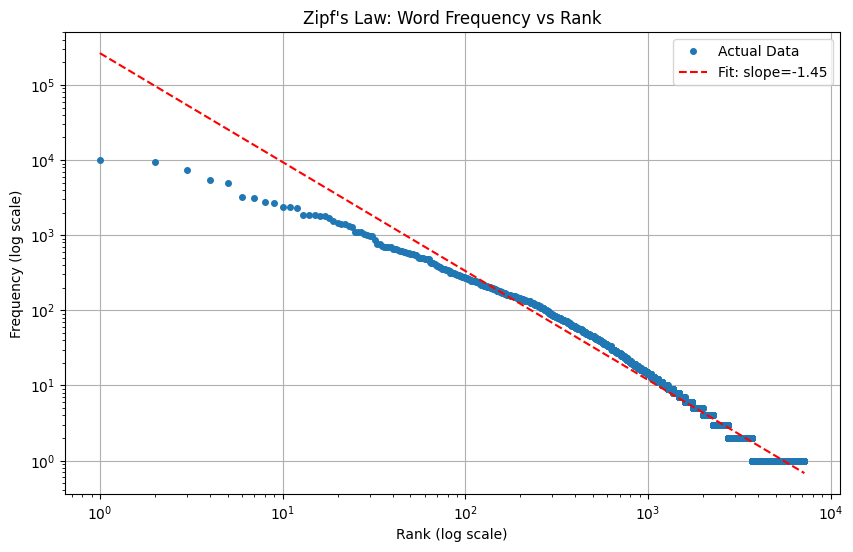

Estimated Zipf's Law exponent: -1.45
Total Words: 185831
Unique Words: 7182
Type-Token Ratio (TTR): 0.038648018898892
Moving Average TTR (MATTR): 0.40440425830401855
Total Rare Types: 3473
Entropy: 8.643327750193
Most Common Words: [('कर', 9907), ('क', 9548), ('आउर', 7399), ('स', 5398), ('म', 4993), ('उ', 3210), ('ह', 3132), ('न', 2798), ('ज', 2716), ('उकर', 2368)]
Root Words (Morphed using Morfessor): ['च प', 'आऊर', 'म ज', 'द ई', 'ठन', 'रह', 'म ज', 'ठन', 'रहल य', 'द ई य', 'म', 'गड़ह', 'दस त', 'रह', 'च प', 'रह', 'द ई य', 'र ज', 'स झ', 'बर', 'रहल य', 'ऊ', 'मन', 'कर', 'ह', 'पसपस', 'रह', 'म', 'ख ल त', 'म', 'ह', 'ऊ', 'मन', 'एक', 'स ग', 'पढ़त', 'रहल य', 'एक', 'द न', 'द ई य', 'झन', 'तय', 'करल य', 'क', 'ऊ मन', 'आऊर', 'कर', 'बह', 'करब य', 'आ गव', 'द न', 'स', 'ह', 'ऊ मन', 'बह', 'कर', 'तय र', 'म', 'ज ई ट', 'ग ल य', 'द ई य', 'झन', 'आपन आपन', 'म य', 'स', 'मदईत', 'मग ल य', 'इन', 'च प', 'कर', 'म य', 'हर', 'ल', 'ल ह ग', 'आऊर', 'द पट ट', 'बनलक', 'उ न', 'म ज', 'कर', 'म य', 'हर', 'कर', 'करत', 'आऊर', 'तय र

In [ ]:
import re
import math
from collections import Counter
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
import morfessor
from morfessor.io import MorfessorIO
from morfessor.baseline import BaselineModel

# Read Chhattisgarhi text from a file
with open('totalsadri.txt', 'r', encoding='utf-8') as file:
    totalsadri = file.read()

# Preprocess the text
def preprocess_text(text):
    # Remove Hindi full stop (।) and double full stop (॥)
    text = re.sub(r'[\u0964\u0965]', '', text)
    # Remove other punctuation marks but keep words and spaces
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Tokenize the text into words using NLTK
def tokenize(text):
    return word_tokenize(text)

# Count the number of sentences
def count_sentences(text):
    sentence_delimiters = r'[\u0964\u0965.!।|?]'
    sentences = re.split(sentence_delimiters, text)
    sentences = [s.strip() for s in sentences if s.strip()]
    return len(sentences)

# Calculate Type-Token Ratio (TTR)
def calculate_ttr(tokens):
    unique_tokens = set(tokens)
    return len(unique_tokens) / len(tokens) if tokens else 0

# Calculate Moving Average TTR (MATTR)
def calculate_mattr(tokens, window_size=500):
    if len(tokens) < window_size:
        return calculate_ttr(tokens)
    mattr_values = [calculate_ttr(tokens[i:i + window_size]) for i in range(len(tokens) - window_size + 1)]
    return sum(mattr_values) / len(mattr_values)

# Calculate entropy
def calculate_entropy(frequencies, total_tokens):
    entropy = -sum((count / total_tokens) * math.log2(count / total_tokens) for count in frequencies.values())
    return entropy

# Perform frequency analysis
def frequency_analysis(words):
    return Counter(words)

# Count rare types (unique words appearing only once)
def count_rare_types(frequencies):
    return sum(1 for count in frequencies.values() if count == 1)

# Function to calculate relative frequency and cumulative coverage of top 10 morphemes
def calculate_relative_and_cumulative(frequencies):
    total_count = sum(frequencies.values())
    sorted_frequencies = frequencies.most_common(10)

    relative_frequencies = {word: count / total_count for word, count in sorted_frequencies}
    cumulative_coverage = []
    cumulative_sum = 0
    for word, count in sorted_frequencies:
        cumulative_sum += count / total_count
        cumulative_coverage.append((word, cumulative_sum))

    return relative_frequencies, cumulative_coverage

    # Compute and plot Zipf's Law
def calculate_zipfs_law(frequencies):
    sorted_frequencies = frequencies.most_common()
    ranks = np.arange(1, len(sorted_frequencies) + 1)
    word_frequencies = np.array([freq for _, freq in sorted_frequencies])
    return ranks, word_frequencies

def plot_zipfs_law(ranks, frequencies):
    plt.figure(figsize=(10, 6))
    plt.loglog(ranks, frequencies, marker="o", linestyle="none", markersize=4, label="Actual Data")

    # Fit a Zipfian curve (linear fit on log-log scale)
    log_ranks = np.log(ranks)
    log_frequencies = np.log(frequencies)
    slope, intercept = np.polyfit(log_ranks, log_frequencies, 1)
    predicted_frequencies = np.exp(intercept) * ranks ** slope

    plt.loglog(ranks, predicted_frequencies, linestyle="dashed", color="red", label=f"Fit: slope={slope:.2f}")
    plt.xlabel("Rank (log scale)")
    plt.ylabel("Frequency (log scale)")
    plt.title("Zipf's Law: Word Frequency vs Rank")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Estimated Zipf's Law exponent: {slope:.2f}")


# Load the trained Morfessor model
def load_morfessor_model(model_path):
    io = MorfessorIO()
    return io.read_binary_model_file(model_path)

# Perform morphological analysis with Morfessor
def analyze_morphology_with_morfessor(model, tokens):
    # Join morphemes with a "+" sign
    morphed_tokens = []
    for token in tokens:
        morphed = model.viterbi_segment(token)[0]
        morphed_with_space = ' '.join(morphed) # Join morphemes with '+'
        morphed_tokens.append(morphed_with_space)
    return morphed_tokens

# Main analysis pipeline
preprocessed_text = preprocess_text(totalsadri)
tokens = tokenize(preprocessed_text)
frequencies = frequency_analysis(tokens)
rare_type_count = count_rare_types(frequencies)
ttr = calculate_ttr(tokens)
sentence_count = count_sentences(totalsadri)
mattr = calculate_mattr(tokens)
entropy = calculate_entropy(frequencies, len(tokens))

# Load the pre-trained Morfessor model
model_path = 'sadri.bin'
morfessor_model = load_morfessor_model(model_path)

# Perform morphological analysis with Morfessor
root_words_morfessor = analyze_morphology_with_morfessor(morfessor_model, tokens)

# Calculate relative frequency and cumulative coverage of top 10 morphemes
relative_frequencies, cumulative_coverage = calculate_relative_and_cumulative(frequencies)

# Calculate and plot Zipf's Law
ranks, word_frequencies = calculate_zipfs_law(frequencies)
plot_zipfs_law(ranks, word_frequencies)

# Display results
print("Total Words:", len(tokens))
print("Unique Words:", len(set(tokens)))
print("Type-Token Ratio (TTR):", ttr)
print("Moving Average TTR (MATTR):", mattr)
print("Total Rare Types:", rare_type_count)
print("Entropy:", entropy)
print("Most Common Words:", frequencies.most_common(10))
print("Root Words (Morphed using Morfessor):", root_words_morfessor[:1000])
print("Total no. of sentences:", sentence_count)
print("Relative Frequencies of Top 10 Morphemes:", relative_frequencies)
print("Cumulative Coverage of Top 10 Morphemes:", cumulative_coverage)


# **Word length Analysis **

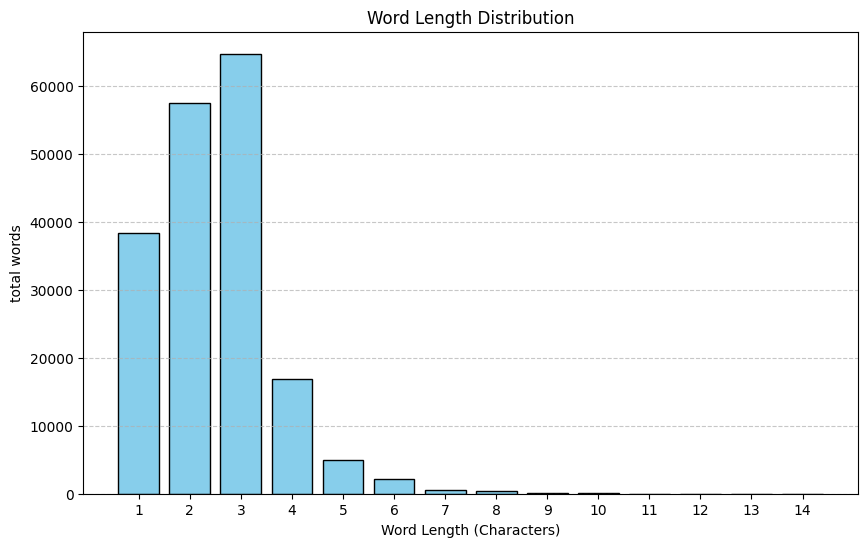

Mean Word Length: 2.481577347159516
Median Word Length: 2.0
Most Common Word Length (Mode): 3


In [ ]:
# Analyze word length in terms of characters
def analyze_word_length(tokens):
    word_lengths = [len(word) for word in tokens]
    length_counts = Counter(word_lengths)
    return length_counts

# Compute statistics for word length
def compute_word_length_stats(word_lengths):
    lengths = list(word_lengths.elements())
    mean_length = np.mean(lengths)
    median_length = np.median(lengths)
    mode_length = max(word_lengths, key=word_lengths.get)
    return mean_length, median_length, mode_length

# Plot word length distribution
def plot_word_length_distribution(word_lengths):
    lengths, counts = zip(*sorted(word_lengths.items()))
    plt.figure(figsize=(10, 6))
    plt.bar(lengths, counts, color="skyblue", edgecolor="black")
    plt.xlabel("Word Length (Characters)")
    plt.ylabel("total words")
    plt.title("Word Length Distribution")
    plt.xticks(lengths)
    plt.grid(axis="y", linestyle="dashed", alpha=0.7)
    plt.show()

    # Analyze word length
token_lengths = analyze_word_length(tokens)
mean_length, median_length, mode_length = compute_word_length_stats(token_lengths)
plot_word_length_distribution(token_lengths)

# Display results
print("Mean Word Length:", mean_length)
print("Median Word Length:", median_length)
print("Most Common Word Length (Mode):", mode_length)



In [1]:
from collections import Counter

# Function to generate character-level n-grams
def get_character_ngrams(text, n):
    return [text[i:i+n] for i in range(len(text) - n + 1)]

# Function to calculate TTR
def calculate_ttr(text, n):
    ngrams = get_character_ngrams(text, n)
    total_ngrams = len(ngrams)
    unique_ngrams = len(set(ngrams))

    if total_ngrams == 0:
        return 0  # Avoid division by zero

    return unique_ngrams / total_ngrams

# Function to calculate MTTR with a window size
def calculate_mttr(text, n, window_size):
    ngrams = get_character_ngrams(text, n)

    if len(ngrams) < window_size:
        return 0  # Not enough n-grams for window

    mttr_values = []
    for i in range(len(ngrams) - window_size + 1):
        window = ngrams[i:i+window_size]
        unique_ngrams = len(set(window))
        mttr_values.append(unique_ngrams / window_size)

    return sum(mttr_values) / len(mttr_values) if mttr_values else 0

# Read Chhattisgarhi text from the file
with open('totalsadri.txt', 'r', encoding='utf-8') as file:
    text = file.read().replace("\n", " ")  # Merge lines into a single text

# Compute TTR and MTTR for n=1 to n=7
window_size = 500  # Define window size for MTTR

for n in range(1, 8):
    ttr = calculate_ttr(text, n)
    mttr = calculate_mttr(text, n, window_size)
    print(f"{n}-gram TTR: {ttr:.4f}, MTTR: {mttr:.4f}")


1-gram TTR: 0.0001, MTTR: 0.0888
2-gram TTR: 0.0024, MTTR: 0.3906
3-gram TTR: 0.0143, MTTR: 0.6377
4-gram TTR: 0.0457, MTTR: 0.7729
5-gram TTR: 0.1042, MTTR: 0.8494
6-gram TTR: 0.1836, MTTR: 0.8975
7-gram TTR: 0.2818, MTTR: 0.9266


# Kenlm installing


In [3]:
!apt install -y cmake build-essential libboost-all-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
libboost-all-dev is already the newest version (1.74.0.3ubuntu7).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [4]:
!git clone https://github.com/kpu/kenlm.git

Cloning into 'kenlm'...
remote: Enumerating objects: 14170, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 14170 (delta 85), reused 56 (delta 56), pack-reused 14047 (from 4)
Receiving objects: 100% (14170/14170), 5.98 MiB | 16.81 MiB/s, done.
Resolving deltas: 100% (8041/8041), done.


# Building dependencies


In [5]:
!cd kenlm && mkdir -p build && cd build && cmake .. && make -j2

CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.10 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value.  Or, use the <min>...<max> syntax
  to tell CMake that the project requires at least <min> but has been updated
  to work with policies introduced by <max> or earlier.


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Could NOT find Eigen3 (missing: Eigen3_DIR)
CMake Warning (dev) at CMakeLists.txt:97 (find_package):
  Policy CMP0167 is n

In [6]:

# Read Chhattisgarhi text from a file
with open('totalsadri.txt', 'r', encoding='utf-8') as file:
    totalsadri = file.read()




# character level based tokeniztion


In [ ]:
def char_tokenize(text):
    return " ".join(text.replace(" ", "_"))  # Replace spaces with "_"


# Open the file, tokenize character-wise, and save it
output_file = "char_tokenized.txt"

with open('totalsadri.txt', "r", encoding="utf-8") as infile, open(output_file, "w", encoding="utf-8") as outfile:
    for line in infile:
        tokenized_line = char_tokenize(line.strip())  # Tokenize line
        outfile.write(tokenized_line + "\n")  # Write tokenized text

print(f"Character-tokenized text saved to: {output_file}")


Character-tokenized text saved to: char_tokenized.txt


# kenlm training

In [7]:
!kenlm/build/bin/lmplz --discount_fallback -o 5 < sadrichar_tokenized.txt > sadri.arpa

=== 1/5 Counting and sorting n-grams ===
Reading /content/sadrichar_tokenized.txt
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 883580 types 84
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:1008 2:1062198784 3:1991622784 4:3186596352 5:4647119872
Substituting fallback discounts for order 0: D1=0.5 D2=1 D3+=1.5
Statistics:
1 84 D1=0.5 D2=1 D3+=1.5
2 2137 D1=0.502318 D2=1.064 D3+=1.43277
3 12865 D1=0.611498 D2=1.10367 D3+=1.48814
4 40009 D1=0.670332 D2=1.12203 D3+=1.51026
5 89745 D1=0.597798 D2=1.09988 D3+=1.44054
Memory estimate for binary LM:
type      kB
probing 2868 assuming -p 1.5
probing 3191 assuming -r models -p 1.5
trie    1000 without quantization
trie     439 assuming -q 8 -b 8 quantization 
trie     944 assuming -a 22 array pointer compression
trie     383 assuming -a 22 -q 8 -b 8 array 

In [8]:
!pip install https://github.com/kpu/kenlm/archive/master.zip


     \ 553.6 kB 9.8 MB/s 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for kenlm: filename=kenlm-0.2.0-cp311-cp311-linux_x86_64.whl size=3186569 sha256=65d4bbe6525ff44de5a4cd8991587a1c99518e7feb16867a3787a019bcbeb0d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-ykbg9nwe/wheels/4e/ca/6a/e5da175b1396483f6f410cdb4cfe8bc8fa5e12088e91d60413
Successfully built kenlm


# evaluating perpexility

In [ ]:
!kenlm/build/bin/query -v summary sadri.arpa < totalsadri.txt


Loading the LM will be faster if you build a binary file.
Reading sadri.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Perplexity including OOVs:	1602.6910114180375
Perplexity excluding OOVs:	145.17242897166545
OOVs:	175203
Tokens:	189882
Name:query	VmPeak:12968 kB	VmRSS:4580 kB	RSSMax:8152 kB	user:0.075882	sys:0.006989	CPU:0.0829328	real:0.08014


In [9]:
import kenlm

def calculate_cross_entropy(model_path, text):
    # Load the KenLM model
    model = kenlm.Model(model_path)

    # Tokenize the input text
    words = text.split()

    # Calculate the log probability of the sequence
    log_prob = model.score(' '.join(words), bos=True, eos=True)

    # Number of words
    num_words = len(words)

    # Cross-entropy calculation
    cross_entropy = -log_prob / num_words

    return cross_entropy

# Example usage
model_path = '/content/sadri.arpa'
file_path = '/content/totalsadri.txt'

# Read text from file
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

entropy = calculate_cross_entropy(model_path, text)
print(f'Cross-Entropy of language: {entropy}')


Cross-Entropy of language: 3.1580020301702114


In [ ]:
import kenlm
model = kenlm.LanguageModel("sadri.arpa")
print("KenLM loaded successfully!")

KenLM loaded successfully!


In [ ]:
!kenlm/build/bin/query -v summary char_model.arpa < test.txt
